<a href="https://colab.research.google.com/github/UdirL18/Horizontalno-prekrivanje-poligonov/blob/main/Horizontalno_prekrivanje_poligonov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Horizontalno prekrivanje poligonov**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import ipywidgets as widgets
from shapely.geometry import Polygon
import scipy.optimize

# plt.style.use('science')

Najprej poskusimo generirati problem na trikotnikih

In [2]:
#poly1 = Polygon(np.random.rand(3,2))  # np.random.rand(m,n) matrika mxn nakljucnih stevil
#poly2 = Polygon(np.random.rand(3,2))  # Polygon "izrise" poligon z danimi koordinatami (3-kotnik, v 2D) 

#poly_inter = poly1.intersection(poly2)


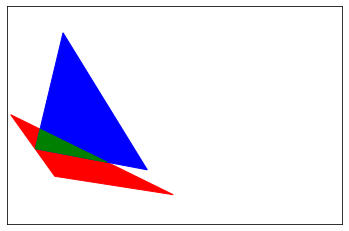

In [3]:
# GENERIRANJE POLJUBNEGA 3-KOTNIKA V RAVNINI
np.random.seed(9)  # zacetnja vrednost za generator nakljucnih stevil
poly1 = Polygon(np.random.rand(3,2))  # np.random.rand(m,n) matrika mxn nakljucnih stevil
poly2 = Polygon(np.random.rand(3,2))  # Polygon izrise poligon z danimi koordinatami (3-kotnik, v 2D) 

poly_inter = poly1.intersection(poly2)  # presek teh dveh poligonov -vrne koordinate preseka

# GRAF
p1 = plt.Polygon(poly1.exterior.coords, color='r')  # zapise tocke ogljisc, naredi poligon iz teh tock
plt.gca().add_patch(p1)  # doda ta poligon na sliko

p2 = plt.Polygon(poly2.exterior.coords, color='b')
plt.gca().add_patch(p2)

p3 = plt.Polygon(poly_inter.exterior.coords, color='g')
plt.gca().add_patch(p3)

plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)  # koordinatni sistem nima oznak

Trikotniki so vedno konveksni. Problem bi radi resevali za poljubne konveksne mnogokotnike. V ta namen moramo sestaviti funkcijo, ki bo preverila ali je poligon konveksen in funkcijo, ki bo zgenerirala taksen poligon.

In [4]:
# FUNKCIJA ZA PREVERJANJE ALI JE POLIGON KONVEKSEN
TWO_PI = 2 * math.pi

def is_convex_polygon(polygon):
    """Return True if the polynomial defined by the sequence of 2D
    points is 'strictly convex': points are valid, side lengths non-
    zero, interior angles are strictly between zero and a straight
    angle, and the polygon does not intersect itself.

    NOTES:  1.  Algorithm: the signed changes of the direction angles
                from one side to the next side must be all positive or
                all negative, and their sum must equal plus-or-minus
                one full turn (2 pi radians). Also check for too few,
                invalid, or repeated points.
            2.  No check is explicitly done for zero internal angles
                (180 degree direction-change angle) as this is covered
                in other ways, including the `n < 3` check.
    """
    try:  # needed for any bad points or direction changes   # ce pride do errorja gre koda v except
        # Check for too few points
        if len(polygon) < 3:  # ce ni vsaj trikotnik
            return False
        # Get starting information
        old_x, old_y = polygon[-2]  # predzadnji x in y iz polygon 
        new_x, new_y = polygon[-1]  # zadnji x in y iz polygon
        new_direction = math.atan2(new_y - old_y, new_x - old_x)  # vrne arctg(new_y - old_y / new_x - old_x) v radijanih med pi in -pi 
        angle_sum = 0.0
        # Check each point (the side ending there, its angle) and accum. angles
        for ndx, newpoint in enumerate(polygon):  # ostevilcimo
            # Update point coordinates and side directions, check side length
            old_x, old_y, old_direction = new_x, new_y, new_direction
            new_x, new_y = newpoint
            new_direction = math.atan2(new_y - old_y, new_x - old_x)
            if old_x == new_x and old_y == new_y:
                return False  # ce je spet ista tocka ni ok
            # Calculate & check the normalized direction-change angle
            angle = new_direction - old_direction  # razlika dveh kotov
            if angle <= -math.pi:  # ce je kot manjsi od -pi 
                angle += TWO_PI  # make it in half-open interval (-Pi, Pi]
            elif angle > math.pi:
                angle -= TWO_PI
            if ndx == 0:  # if first time through loop, initialize orientation
                if angle == 0.0:
                    return False
                orientation = 1.0 if angle > 0.0 else -1.0
            else:  # if other time through loop, check orientation is stable
                if orientation * angle <= 0.0:  # not both pos. or both neg.
                    return False
            # Accumulate the direction-change angle
            angle_sum += angle
        # Check that the total number of full turns is plus-or-minus 1
        return abs(round(angle_sum / TWO_PI)) == 1
    except (ArithmeticError, TypeError, ValueError):
        return False  # any exception means not a proper convex polygon

In [5]:
# FUNKCIJA ZA GENERIRANJE NAKLJUCNIH POLIGONOV
def gen_rand_poly(n=3):
    for i in range(1_000_000):
        cords = np.random.rand(n, 2)  # matrika z n vrsticami in 2 stolpcema 
        u = np.argsort(np.arctan2(*cords.T))  # .T transponira koordinate, argsort vrne indekse ki bi uredili array
 
        cords = cords[u, :]  # uredimo koordinate po velikosti
        if is_convex_polygon(cords):
            return Polygon(cords)  # ce je poligon konveksen "izrise" poligon

In [6]:
# IZRIS POLIGONOV
def plot_polys(*args):
    for i, poly in enumerate(args):
        cords = np.array(poly.exterior.coords)[:-1, :]
        plt.scatter(*cords.T, s=0)  # narise tocke
        p = plt.Polygon(cords, color=get_cmap('Set1')(i), alpha=0.7)
        plt.gca().add_patch(p)
        plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

In [ ]:
#plot_polys(poly1, poly2)  # takole narises dva poligona na isto sliko

Za iskanje minimalnega vodoravnega premika sestavimo funkcijo, ki omogoca premikanje poligonov na sliki.

In [7]:
def move_polygon(poly, x):
    cords = np.array(poly.exterior.coords)[:-1,:]  # koordinate oglisc zapise v np.array
    cords[:, 0] += x  # vse x koordinate premakne za dani x
    poly = Polygon(cords) 
    return poly  # vrne premaknen poligon

In [8]:
p1 = plt.Polygon(poly1.exterior.coords, color='r')

# FUNKCIJA, KI NAM OMOGOCA PREMIKANJE POLIGONOV S POMOCJO 'SLAJDERJA'.
def move_windget_fun(x=0):
    fig, ax = plt.subplots()
    
    poly = move_polygon(poly1, x=x)
    plot_polys(poly, poly2)
#     p1 = plt.Polygon(poly.exterior.coords, color='r')
#     ax.add_patch(p1)
    
#     p2 = plt.Polygon(poly2.exterior.coords, color='g')
#     ax.add_patch(p2)
    
    txt = f'A_intersect = 0.0000'

    if poly.intersects(poly2):
        poly3 = poly.intersection(poly2)
        p3 = plt.Polygon(poly3.exterior.coords, color=get_cmap('Set1')(2))
        ax.add_patch(p3)
        txt = f'A_intersect = {poly3.area:.4f}'
    
    ax.text(1,1,txt, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
#     plt.xlim(-1, 1)
#     plt.ylim(-1, 1)
    plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
    plt.show()

widgets.interact(move_windget_fun, x=(-1, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, min=-1.0, step=0.05), Output()), _dom_c…

Zapiseva funkcijo, ki bo poiskala potreben minimalni premik rdečega poligona v smeri abcisne osi, da rdeč in moder poligon postaneta disjunkta.

In [9]:
def min_dist_f(x, poly1, poly2):
    poly = move_polygon(poly1, x)
    A = poly.intersection(poly2).area  # ploscina (npr. 0.010113566098373444)
    d = poly.distance(poly2)  # ce se prekrivata
    return A - d  # ko bosta poligona disjunktna se bo d poveceval in bo ta vrednost vedno manjsa, ko no A > 0 bo d enak nic, poiskati moramo ničlo te funkcije

In [11]:
# IZRACUN NA ZACETNEM PRIMERU
min_dist_f(0.1, poly1, poly2)
# min_dist_f(-0.1, poly1, poly2)

0.02102339168383386

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Text(-0.13255216255988858, 0, '-0.13')

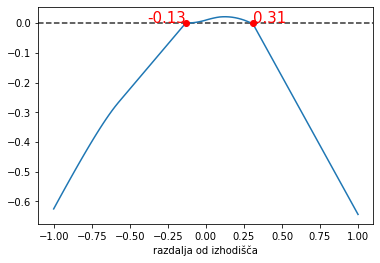

In [13]:
# IZRIS GRAFA
xx = np.linspace(-1, 1, 100)
y = np.vectorize(min_dist_f)(xx, poly1, poly2)
#plt.style.use(['science', 'notebook'])
fig, ax = plt.subplots(figsize=(6,4))
ax.axhline(0, c='k', ls='--', alpha=0.8)
ax.plot(xx, y)
ax.set_xlabel("razdalja od izhodišča")
# ax.grid(ls='--')

# ISKANJE NIČEL - tj rdeči pikici na grafu
x1 = scipy.optimize.newton(min_dist_f, x0=0.5, args=(poly1, poly2))
ax.plot(x1, 0, 'ro')
ax.text(x1, 0, f'{x1:.2f}', fontsize=15, c='r')

x2 = scipy.optimize.newton(min_dist_f, x0=-0.5, args=(poly1, poly2))
ax.plot(x2, 0, 'ro')
ax.text(x2, 0, f'{x2:.2f}', fontsize=15, c='r', horizontalalignment='right')

# ZA SHRANJEVANJE SLIKE ZA pdf
#plt.savefig('funkcija.pdf', bbox_inches='tight')

Izračun najmanjse ničle po absolutni vrednosti zgornje funkcije.

In [18]:
min_dist = scipy.optimize.newton(min_dist_f, x0=1e-3, args=(poly1, poly2))

print(f'Najmanjša razdalja za premik rdečega poligona je {min_dist:.4f}')

Najmanjša razdalja za premik rdečega poligona je -0.4799


In [15]:
# Primer
poly1 = gen_rand_poly(n=6)
poly2 = gen_rand_poly(n=9)

widgets.interact(move_windget_fun, x=(-2, 2, 0.1));

interactive(children=(FloatSlider(value=0.0, description='x', max=2.0, min=-2.0), Output()), _dom_classes=('wi…

In [19]:
min_dist = scipy.optimize.newton(min_dist_f, x0=1e-3, args=(poly1, poly2))

print(f'Najmanjša razdalja za premik rdečega poligona je {min_dist:.4f}')

Najmanjša razdalja za premik rdečega poligona je -0.4799


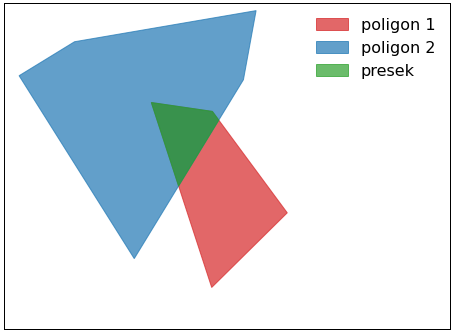

In [ ]:
# Primer
poly1 = gen_rand_poly(n=4)
poly2 = gen_rand_poly(n=5)

p1 = plt.Polygon(poly1.exterior.coords, color='tab:red', alpha=0.7, label='poligon 1')  # zapise tocke ogljisc, naredi poligon iz teh tock
plt.gca().add_patch(p1)  # doda ta poligon na sliko

p2 = plt.Polygon(poly2.exterior.coords, color='tab:blue', alpha=0.7, label='poligon 2')
plt.gca().add_patch(p2)

poly_inter = poly1.intersection(poly2)
p3 = plt.Polygon(poly_inter.exterior.coords, color='tab:green', alpha=0.7, label='presek')
plt.gca().add_patch(p3)

plt.tick_params(which='both', bottom=False, left=False, top=False, right=False,  labelleft=False, labelbottom=False, axis='both')  # koordinatni sistem nima oznak
plt.legend()
plt.savefig('poligona.pdf', bbox_inches='tight')